In [45]:
from torch_geometric.data import Data
import torch
from torch import load, save, tensor

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import pubchempy as pcp
import sys
import re


# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.dataset import OxidesGraphDataset
from oxides_ml.graph_tools import graph_plotter

graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "second_order": True},
                "features": {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False},
                "target": "adsorption_energy"}

vasp_directory = "/BACKUP/database"
graph_dataset_dir = "/home/tvanhout/oxides_ML/models/test_graph_datasets"

dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params, initial_state=False, force_reload=False, augment=False)
len(dataset)

Force reloading: deleting existing dataset at /home/tvanhout/oxides_ML/models/test_graph_datasets/database_adsorption_energy_025_125_True_False_False_False_False_False_relaxed_False


Processing...


Isomorphism detected for C2H6O
Isomorphism detected for C3H9N
Isomorphism detected for C2H5N
Isomorphism detected for CH3NO
Isomorphism detected for C2H6S
Isomorphism detected for C2H4O81Ru40
Isomorphism detected for C2H4O81Ru40
Isomorphism detected for CH2O81Ru40
Isomorphism detected for CH4O81Ru40
Isomorphism detected for CH4O81Ru40
Isomorphism detected for CH4O81Ru40
Isomorphism detected for CH4O81Ru40
Isomorphism detected for C3H8O81Ru40
Isomorphism detected for C3H6O81Ru40
Isomorphism detected for C2H6O80Ru40
Isomorphism detected for C2H6O80Ru40
Isomorphism detected for C2H4O80Ru40
Isomorphism detected for CH4O80Ru40
Isomorphism detected for CH4O80Ru40
Isomorphism detected for CH4O80Ru40
Isomorphism detected for C3H6O80Ru40
Isomorphism detected for C3H6O80Ru40
Isomorphism detected for C3H6O80Ru40
Isomorphism detected for C2H7NO80Ru40
Isomorphism detected for CH5NO80Ru40
Isomorphism detected for C3H9NO80Ru40
Isomorphism detected for C3H9NO80Ru40
Isomorphism detected for C3H9NO80Ru4

Done!


560

# Determine Connectivity

In [46]:
def subtract_graphs(G_total, G_slab, G_gas):
    """Subtracts the slab and gas-phase graphs from the total graph to extract adsorbate connectivity."""
    # Combine edges from slab and gas-phase molecule
    combined_edges = torch.cat([G_slab.edge_index, G_gas.edge_index], dim=1)
    
    # Identify new edges in G_total that are not in the combined system
    mask = ~(G_total.edge_index.unsqueeze(2) == combined_edges.unsqueeze(1)).all(dim=0).any(dim=1)
    new_edges = G_total.edge_index[:, mask]

    # Extract corresponding edge attributes (adsorbate-specific edges)
    new_edge_attr = None
    if G_total.edge_attr is not None:
        new_edge_attr = G_total.edge_attr[mask]  # Only keep the edge attributes for the new edges

    # Extract new node features (adsorbate-specific)
    new_node_features = None
    if G_total.x is not None and G_slab.x is not None and G_gas.x is not None:
        num_slab_nodes = G_slab.x.shape[0]
        num_gas_nodes = G_gas.x.shape[0]
        new_node_features = G_total.x[num_slab_nodes + num_gas_nodes:]  # Adsorbate-specific nodes

    # Create the new graph for the adsorbate
    G_adsorbate = Data(x=new_node_features, edge_index=new_edges, edge_attr=new_edge_attr)

    # Copy over all other features from G_total to G_adsorbate
    G_adsorbate.elem = G_total.elem  # Element types of the nodes
    G_adsorbate.formula = G_total.formula  # Chemical formula
    G_adsorbate.facet = G_total.facet  # Facet type
    G_adsorbate.spin_polarization = G_total.spin_polarization  # Spin polarization data
    G_adsorbate.energy = G_total.energy  # Total energy
    G_adsorbate.slab_energy = G_total.slab_energy  # Slab energy
    G_adsorbate.adsorbate_energy = G_total.adsorbate_energy  # Adsorbate energy
    G_adsorbate.ads_energy = G_total.ads_energy  # Adsorption energy
    G_adsorbate.target = G_total.target  # Target values (adsorption energies)
    
    # If available, attach more attributes like material, adsorbate_name, and adsorbate_group
    if hasattr(G_total, "material"):
        G_adsorbate.material = G_total.material
    if hasattr(G_total, "adsorbate_name"):
        G_adsorbate.adsorbate_name = G_total.adsorbate_name
    if hasattr(G_total, "adsorbate_group"):
        G_adsorbate.adsorbate_group = G_total.adsorbate_group

    return G_adsorbate

G_gas = None
G_slab = None
G_totals = []  # Store all adsorbate configurations
G_adsorbate_list = []  # List to store all computed G_adsorbate graphs

# Step 1: Extract relevant graphs from dataset
for graph in dataset:
    if graph.adsorbate_name == graph.adsorbate_name and graph.type == 'gas':
        G_gas = graph  # Gas-phase molecule
    elif graph.material == graph.material and graph.type == 'slab':
        G_slab = graph  # Clean slab
    elif graph.adsorbate_name == graph.adsorbate_name and graph.material == graph.material and graph.type == 'adsorbate':
        G_totals.append(graph)  # Collect all adsorption configurations

# Step 2: Check if necessary components exist
if G_gas is None:
    print("Error: Gas-phase molecule graph not found.")
if G_slab is None:
    print("Error: Slab graph not found.")
if len(G_totals) == 0:
    print("Error: No adsorption graphs found.")

# Step 3: Compute and store G_adsorbate for each adsorption instance
for idx, G_total in enumerate(G_totals):
    G_adsorbate = subtract_graphs(G_total, G_slab, G_gas)
    G_adsorbate_list.append(G_adsorbate)  # Append to the list

    # Print energy to verify it's being stored correctly
    #print(f"Graph {idx}: Adsorption Energy = {G_adsorbate.ads_energy}")

# Step 4: Verify that results are stored
print(f"Number of extracted adsorbate graphs: {len(G_adsorbate_list)}")

# for graph in G_adsorbate_list:
#     print(graph)

Number of extracted adsorbate graphs: 525


# Determine adsorption sites (relaxed)

In [47]:
def find_adsorption_sites(G_adsorbate, G_slab):
    """Identify adsorption site by finding slab atoms connected to the adsorbate in G_adsorbate."""
    adsorption_sites = set()

    # Assume the adsorbate starts after slab nodes in G_total
    num_slab_nodes = G_slab.x.shape[0]

    for edge in G_adsorbate.edge_index.T:  # Iterate over edges
        node1, node2 = edge.tolist()

        # One node must be from the slab, the other from the adsorbate
        if (node1 < num_slab_nodes and node2 >= num_slab_nodes) or (node2 < num_slab_nodes and node1 >= num_slab_nodes):
            adsorption_sites.add(node1 if node1 < num_slab_nodes else node2)  # Store slab atom index

    return sorted(list(adsorption_sites))  # Return sorted slab atom indices

# Example: Process all adsorbate graphs
adsorption_sites_list = []

for idx, G_adsorbate in enumerate(G_adsorbate_list):
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    adsorption_sites_list.append(adsorption_sites)
    
    # print(f"Graph {idx}: Adsorption Sites = {adsorption_sites}")


In [48]:
# Dictionary to store unique adsorption sites
unique_adsorption_sites = defaultdict(int)

# Iterate over the list of G_adsorbate graphs and track adsorption sites
for idx, G_adsorbate in enumerate(G_adsorbate_list):
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    
    # Convert list to a tuple to make it hashable for storage in a dictionary
    adsorption_sites_tuple = tuple(sorted(adsorption_sites))  # Ensure the list is sorted to normalize order
    
    # Increment count of this unique adsorption site
    unique_adsorption_sites[adsorption_sites_tuple] += 1

# Now you have all unique adsorption site configurations with their frequency count
# Print out unique adsorption sites and how often they occur
print("Unique Adsorption Site Configurations and Their Counts:")
for sites, count in unique_adsorption_sites.items():
    print(f"Adsorption Sites: {sites}, Count: {count}")

Unique Adsorption Site Configurations and Their Counts:
Adsorption Sites: (34,), Count: 11
Adsorption Sites: (4,), Count: 13
Adsorption Sites: (24,), Count: 207
Adsorption Sites: (4, 24), Count: 63
Adsorption Sites: (), Count: 141
Adsorption Sites: (24, 109), Count: 22
Adsorption Sites: (69, 109), Count: 5
Adsorption Sites: (19, 69, 109), Count: 3
Adsorption Sites: (4, 24, 69), Count: 8
Adsorption Sites: (4, 24, 109), Count: 20
Adsorption Sites: (14, 69), Count: 1
Adsorption Sites: (4, 24, 89), Count: 10
Adsorption Sites: (14, 34, 69), Count: 2
Adsorption Sites: (24, 89), Count: 2
Adsorption Sites: (4, 49), Count: 2
Adsorption Sites: (4, 24, 39, 109), Count: 1
Adsorption Sites: (14, 34), Count: 2
Adsorption Sites: (34, 69, 109), Count: 2
Adsorption Sites: (4, 24, 69, 109), Count: 1
Adsorption Sites: (109,), Count: 5
Adsorption Sites: (34, 109), Count: 3
Adsorption Sites: (4, 69), Count: 1


In [49]:
# Define the mapping from adsorption site configurations to labels
adsorption_site_map = {
    (34,): 'Metal',
    (4,): 'Metal',
    (24,): 'Metal',
    (4, 24): 'Metal Bridge',
    (): 'Physisorbed',
    (24, 109): 'Hole',
    (69, 109): 'Oxygen Bridge',
    (19, 69, 109): 'Oxygen Bridge',
    (4, 24, 69): 'Metal Bridge',
    (4, 24, 109): 'Metal Bridge',
    (14, 69): 'Metal',
    (4, 24, 89): 'Metal Bridge',
    (14, 34, 69): 'Metal Bridge',
    (24, 89): 'Metal',
    (4, 49): 'Metal',
    (4, 24, 39, 109): 'Metal Bridge',
    (14, 34): 'Metal Bridge',
    (34, 69, 109): 'Oxygen Bridge',
    (4, 24, 69, 109): 'Metal Bridge',
    (109,): 'Oxygen',
    (4, 69): 'Metal',
    (34, 109): 'Metal'
}

def classify_adsorption_sites(adsorption_sites):
    """Assigns a label based on the adsorption site positions using predefined map."""
    adsorption_sites_tuple = tuple(sorted(adsorption_sites))  # Sort to standardize the representation
    return adsorption_site_map.get(adsorption_sites_tuple, 'Unknown')  # Default to 'Unknown' if not found

def assign_adsorption_label(G_adsorbate):
    """Assigns a string label to the graph based on adsorption site."""
    adsorption_sites = find_adsorption_sites(G_adsorbate, G_slab)
    label = classify_adsorption_sites(adsorption_sites)  # Get the label based on adsorption site
    return label

# Step 1: Assign labels to each graph in G_adsorbate_list
for idx, G_adsorbate in enumerate(G_adsorbate_list):
    label = assign_adsorption_label(G_adsorbate)
    G_adsorbate.adsorption_label = label  # Assign the label as a property of the graph

    # Optional: Print the label for each graph
    # print(f"Graph {idx}: Adsorption Label = {label}")

# for graph in G_adsorbate_list:
#     print(graph)

In [50]:
# for graph in G_adsorbate_list:
#     if graph.adsorption_label == 'Physisorbed':
#         graph_plotter(graph)

# Data analysis of dataset

In [71]:
data = []
for G_adsorbate in G_adsorbate_list:
    # Create a dictionary for each graph's information
    graph_data = {
        "material": getattr(G_adsorbate, "material", None),  # Surface material
        "adsorbate_group": getattr(G_adsorbate, "adsorbate_group", None),  # Adsorbate group
        "adsorbate_name": getattr(G_adsorbate, "adsorbate_name", None),  # Adsorbate name
        "adsorption_label": getattr(G_adsorbate, "adsorption_label", None),  # Adsorption label
        "ads_energy": G_adsorbate.ads_energy.item() if G_adsorbate.ads_energy is not None else None,  # Convert tensor to value
    }
    data.append(graph_data)

df = pd.DataFrame(data)

# df.head(10)

In [73]:
surface_counts = df['material'].value_counts()

result_df = pd.DataFrame({
    'Label': surface_counts.index,
    'Count': surface_counts.values,
})

result_df


,Label,Count
0,RuO2,268
1,IrO2,257


In [56]:
label_counts = df['adsorption_label'].value_counts()

label_percentages = (label_counts / len(df)) * 100

result_df = pd.DataFrame({
    'Label': label_counts.index,
    'Count': label_counts.values,
    'Percentage': label_percentages.values
})

result_df

,Label,Count,Percentage
0,Metal,240,45.714286
1,Physisorbed,141,26.857143
2,Metal Bridge,107,20.380952
3,Hole,22,4.190476
4,Oxygen Bridge,10,1.904762
5,Oxygen,5,0.952381


In [ ]:
# empty_adsorption_sites_df = df[df['adsorption_label'] == 'Physisorbed']

# empty_adsorption_sites_df.head(20)

# test = []
# for graph in dataset:
#     if graph.adsorbate_name == "Formaldehyde":
#         test.append(graph)

# test[2].ads_energy

# graph_plotter(test[9], node_index=False)

/tmp/ipykernel_2361897/3602221888.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


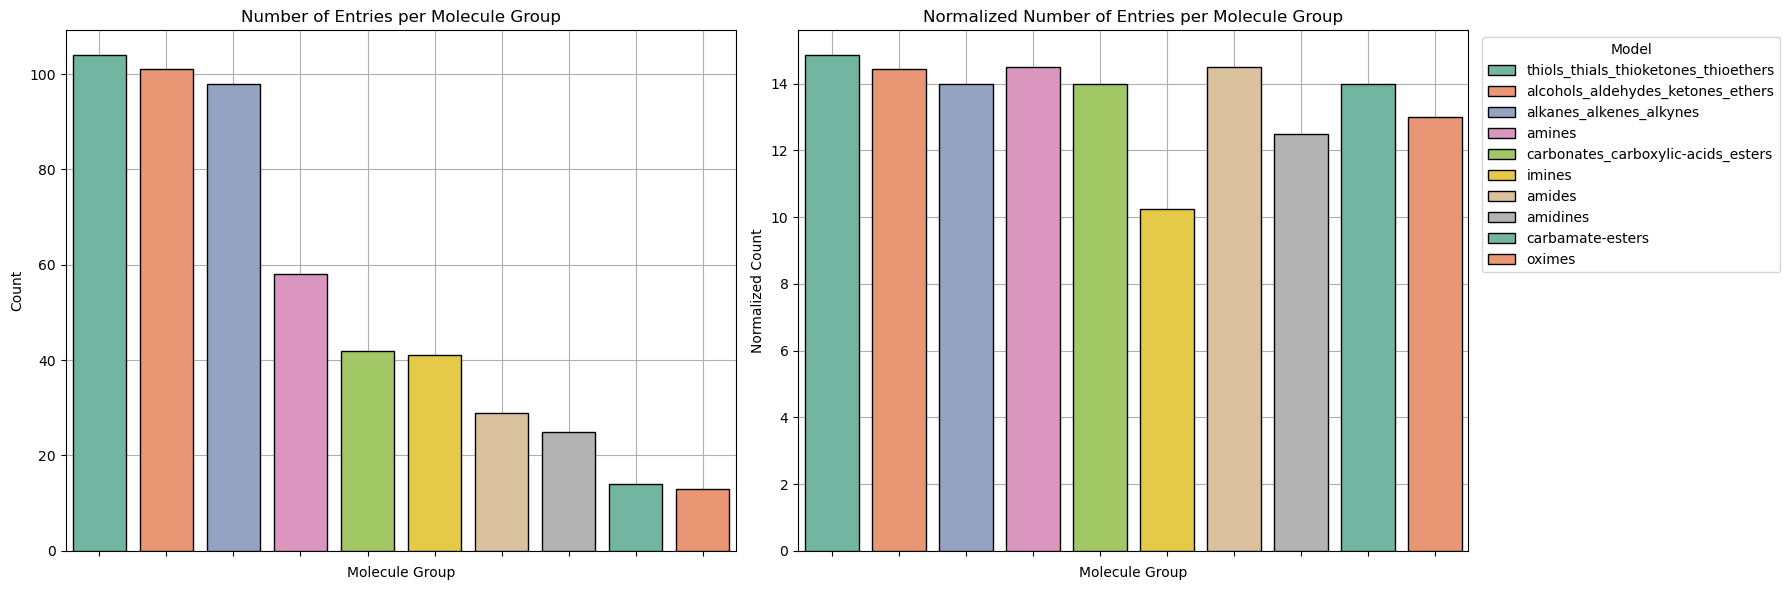

In [69]:
group_counts = df['adsorbate_group'].value_counts().reset_index()
group_counts.columns = ["adsorbate_group", "count"]

molecule_counts = df.groupby("adsorbate_group")["adsorbate_name"].nunique().reset_index()
molecule_counts.columns = ["adsorbate_group", "total_molecules"]

group_counts = group_counts.merge(molecule_counts, on="adsorbate_group")
group_counts["normalized_count"] = group_counts["count"] / group_counts["total_molecules"]


fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# First plot: Count of each adsorption group
sns.barplot(x="adsorbate_group", y="count", data=group_counts, hue="adsorbate_group", palette="Set2", legend=False, edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("Number of Entries per Molecule Group")
axes[0].set_xlabel("Molecule Group")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_xticklabels([])
axes[0].grid(True)

# Second plot: Normalized count per adsorption group
sns.barplot(x="adsorbate_group", y="normalized_count", data=group_counts, hue="adsorbate_group", palette="Set2", legend=True, edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Normalized Number of Entries per Molecule Group")
axes[1].set_xlabel("Molecule Group")
axes[1].set_ylabel("Normalized Count")
#axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_xticklabels([])
axes[1].grid(True)
axes[1].legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()


# Global Energy Distribution

/tmp/ipykernel_2361897/3358031228.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x="ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10,  ax=axes[0])


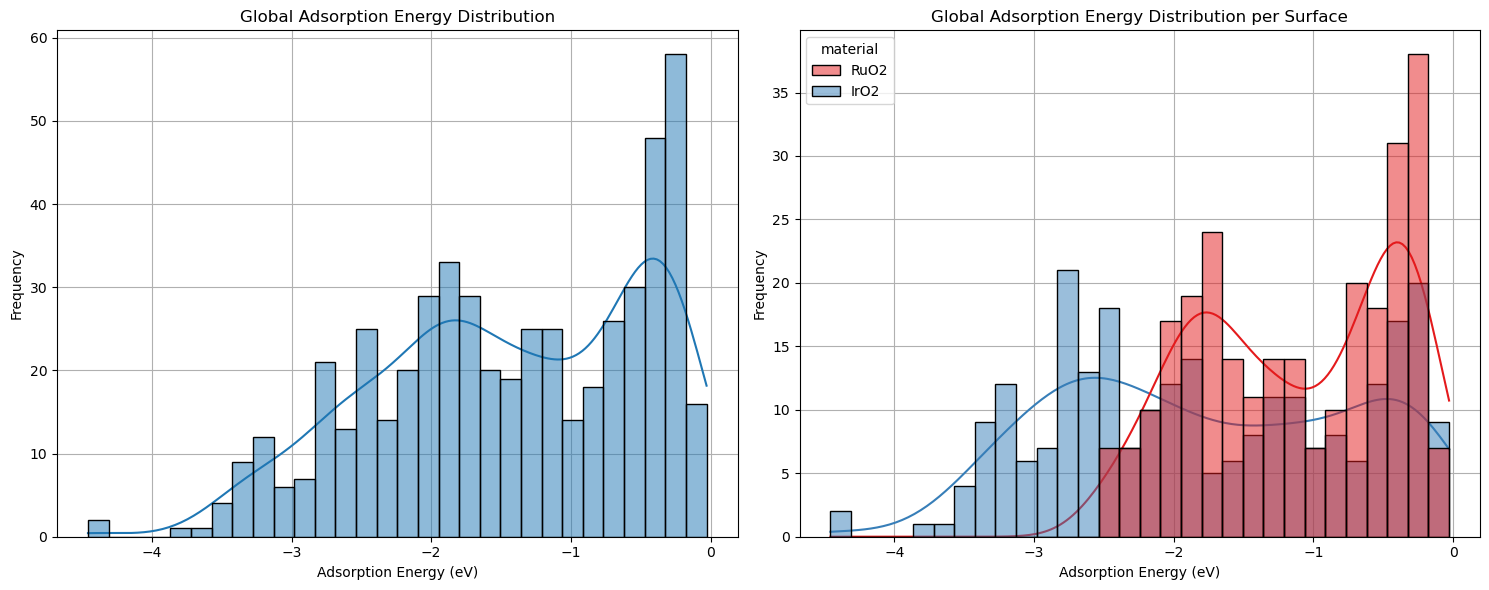

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# First plot
sns.histplot(df, x="ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10,  ax=axes[0])
axes[0].set_title("Global Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df, x="ads_energy", hue="material", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Global Adsorption Energy Distribution per Surface")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

# Final site insights

/tmp/ipykernel_2361897/1401505413.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


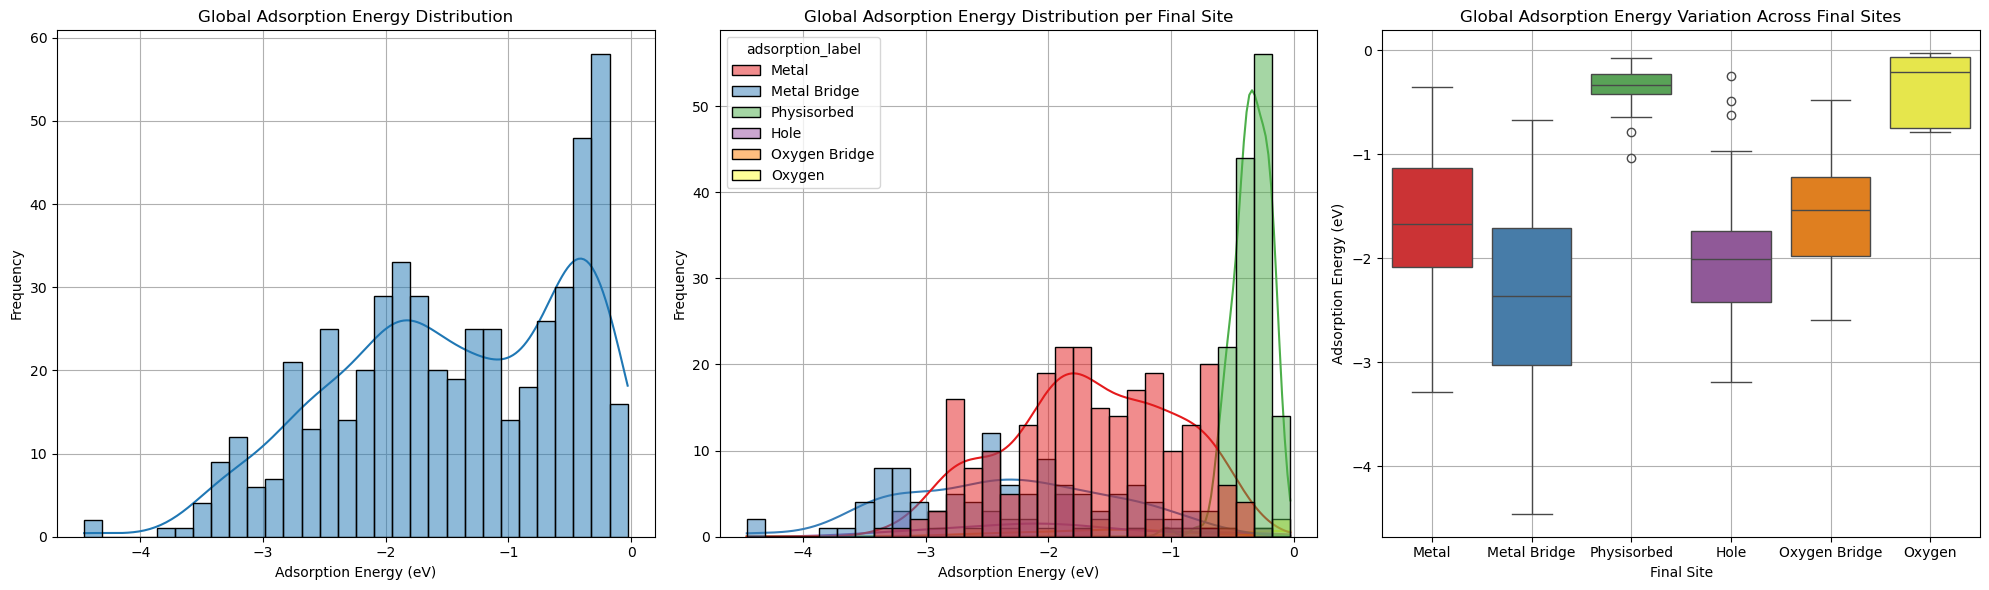

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("Global Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df, x = "ads_energy", hue = 'adsorption_label', bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Global Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False , ax=axes[2])
axes[2].set_title("Global Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_2361897/1998332539.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


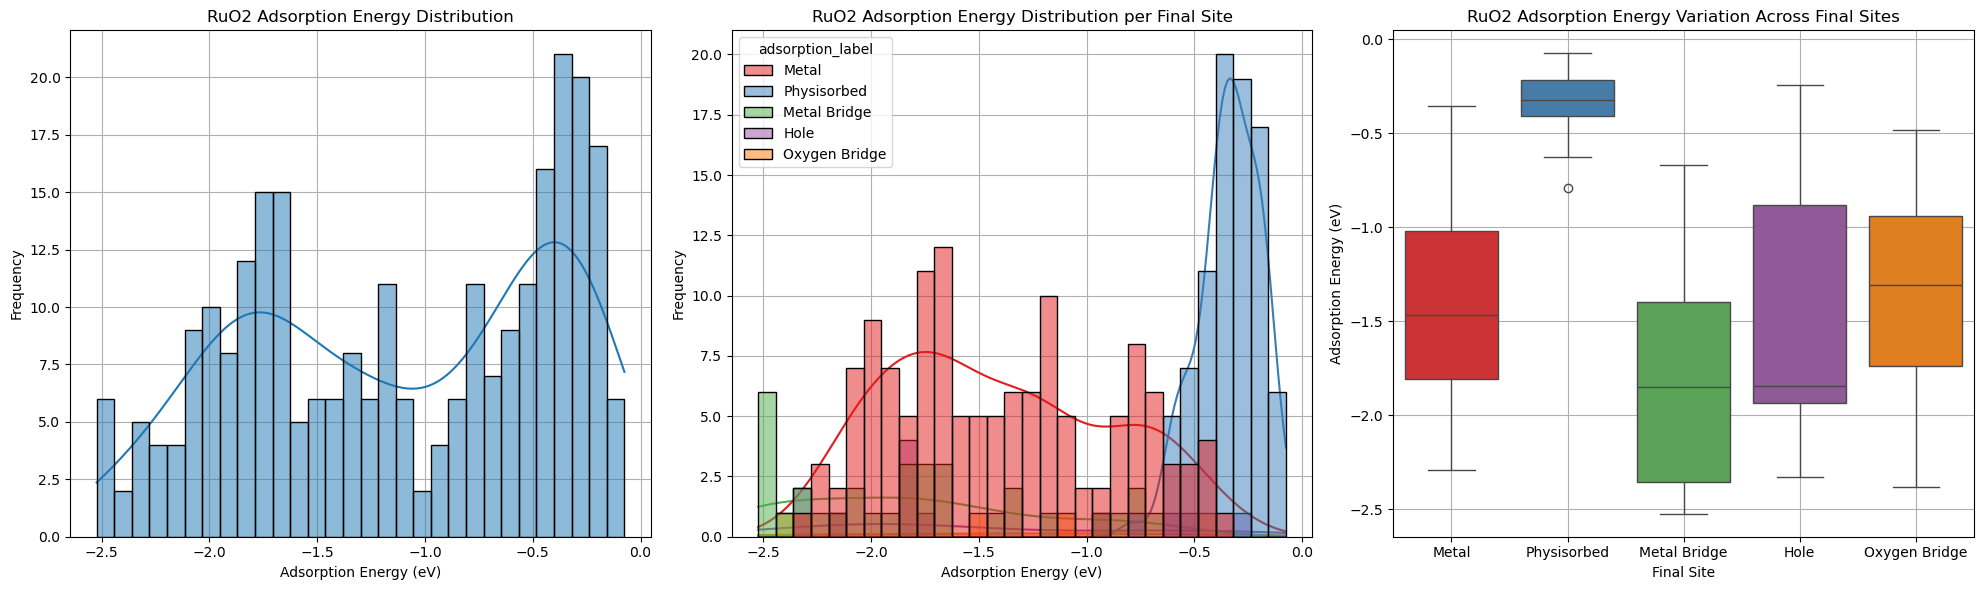

In [60]:
df_RuO2 = df[df['material'] == 'RuO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("RuO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_RuO2, x = "ads_energy", hue = 'adsorption_label' , bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("RuO2 Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_RuO2, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("RuO2 Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_2361897/2103276201.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


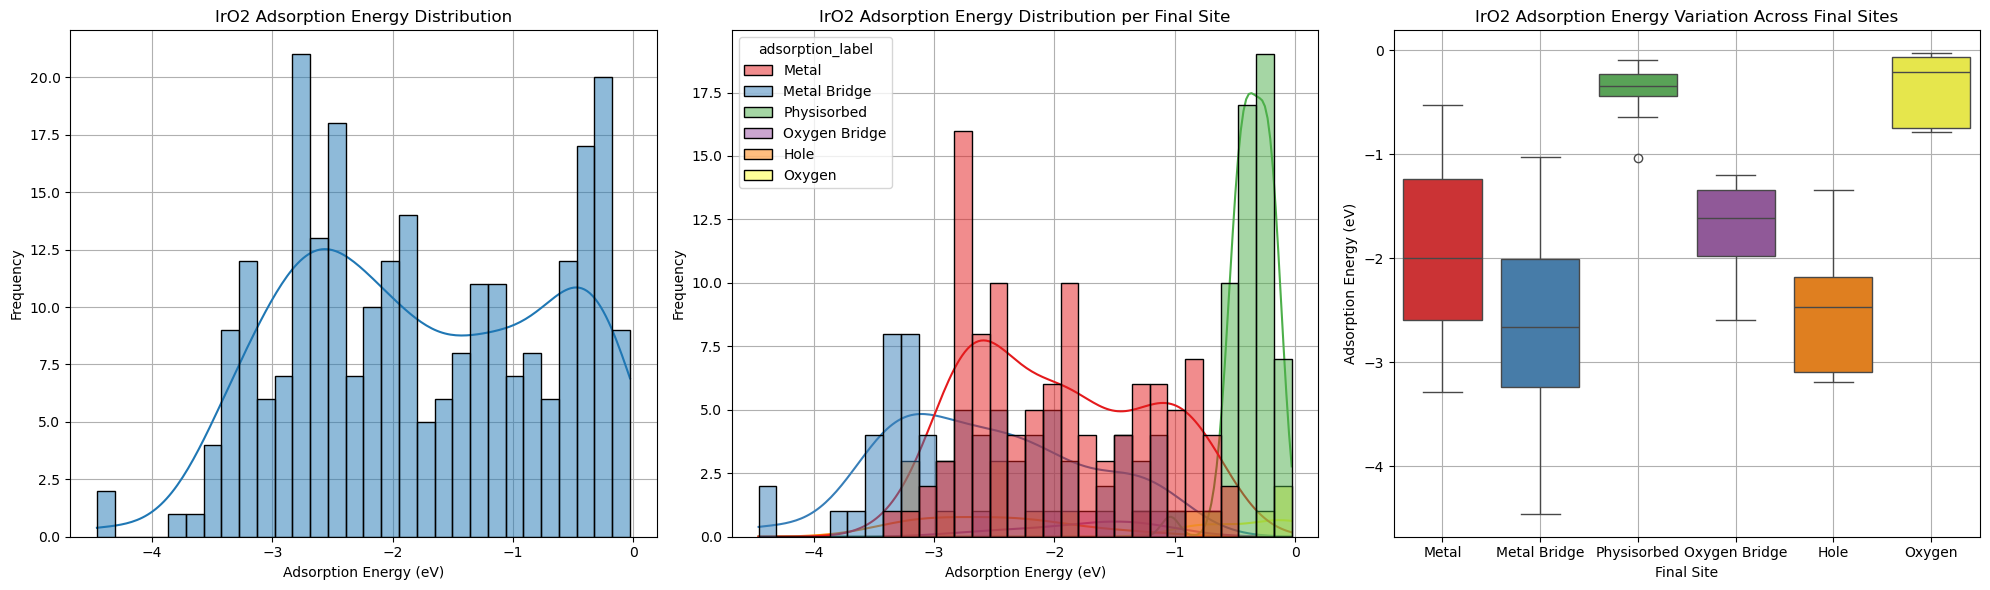

In [61]:
df_IrO2 = df[df['material'] == 'IrO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("IrO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_IrO2, x = "ads_energy", hue = 'adsorption_label' , bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("IrO2 Adsorption Energy Distribution per Final Site")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_IrO2, x="adsorption_label", y="ads_energy", hue = "adsorption_label", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("IrO2 Adsorption Energy Variation Across Final Sites")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

In [62]:
# # Function to get molecular formula from PubChem
# def get_molecular_formula(molecule_name):
#     try:
#         compound = pcp.get_compounds(molecule_name, 'name')
#         if compound:
#             return compound[0].molecular_formula  # Retrieve molecular formula
#     except:
#         return None  # Return None if PubChem lookup fails

# # Function to count elements from molecular formula
# def count_elements(formula):
#     element_counts = defaultdict(int)
    
#     if formula:
#         # Regex to find elements and their counts (e.g., C2, H6, O)
#         matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
        
#         for element, count in matches:
#             element_counts[element] = int(count) if count else 1  # Default count to 1 if missing
    
#     return element_counts

# # Retrieve molecular formulas
# df['formula'] = df['adsorbate_name'].apply(get_molecular_formula)

# # Extract counts of elements (C, S, N, H, O)
# for element in ['C', 'S', 'N', 'H', 'O']:
#     df['number_of_' + element] = df['formula'].apply(lambda x: count_elements(x).get(element, 0))


In [63]:
df.head()

,material,adsorbate_group,adsorbate_name,adsorption_label,ads_energy
0,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.285223
1,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.376368
2,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-0.494098
3,RuO2,alcohols_aldehydes_ketones_ethers,Acetaldehyde,Metal,-1.376956
4,RuO2,alcohols_aldehydes_ketones_ethers,Ethanol,Metal Bridge,-1.717263


/tmp/ipykernel_2361897/711906720.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_IrO2_metal, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
/tmp/ipykernel_2361897/711906720.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Fixed rotation


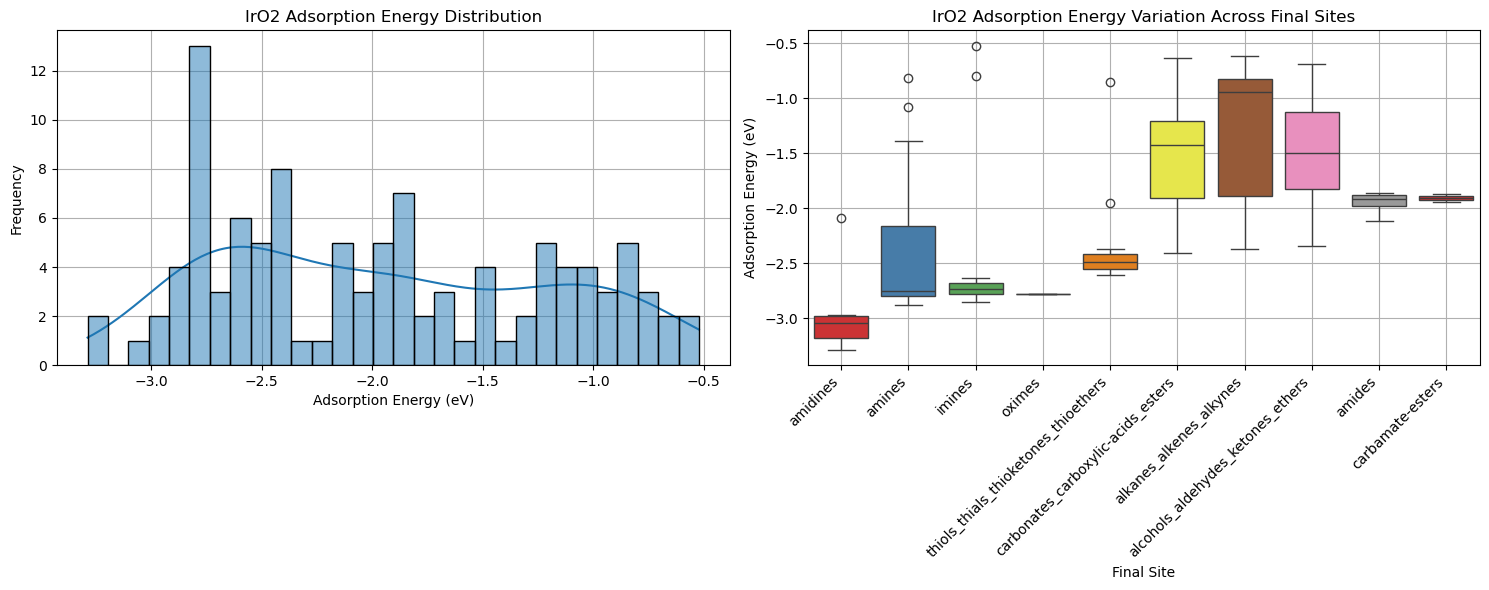

In [64]:
df_IrO2 = df[df['material'] == 'IrO2'].sort_values(by=['ads_energy']).reset_index(drop=True)
df_IrO2_metal = df_IrO2[df_IrO2['adsorption_label'] == 'Metal'].reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_IrO2_metal, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("IrO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# # Second plot
# sns.histplot(df_IrO2_metal, x = "ads_energy", hue = 'adsorbate_group' , bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
# axes[1].set_title("IrO2 Adsorption Energy Distribution per Final Site")
# axes[1].set_xlabel("Adsorption Energy (eV)")
# axes[1].set_ylabel("Frequency")
# axes[1].grid(True)

# Second plot
# sns.boxplot(df_IrO2_metal, x="adsorbate_group", y="ads_energy", hue = "adsorbate_group", palette="Set1", legend=False, ax=axes[2])
# axes[2].set_title("IrO2 Adsorption Energy Variation Across Final Sites")
# axes[2].set_ylabel("Adsorption Energy (eV)")
# axes[2].set_xlabel("Final Site")
# axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Fixed rotation
# axes[2].grid(True)

sns.boxplot(df_IrO2_metal, x="adsorbate_group", y="ads_energy", hue = "adsorbate_group", palette="Set1", legend=False, ax=axes[1])
axes[1].set_title("IrO2 Adsorption Energy Variation Across Final Sites")
axes[1].set_ylabel("Adsorption Energy (eV)")
axes[1].set_xlabel("Final Site")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Fixed rotation
axes[1].grid(True)



# Adjust layout
plt.tight_layout()

plt.show()

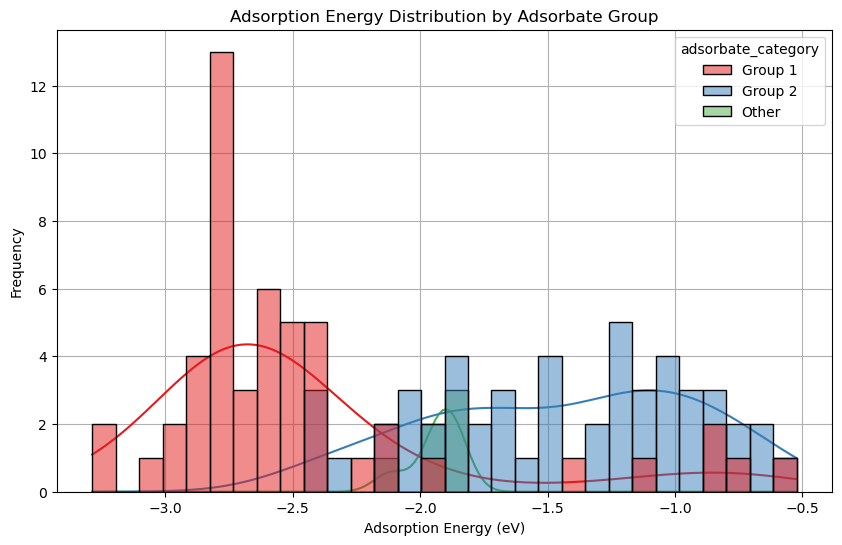

In [65]:
group_1 = ["amidines", "amines", "imines", "oximes", "thiols_thials_thioketones_thioethers"]  # Example Group 1
group_2 = [ "alcohols_aldehydes_ketones_ethers", "alkanes_alkenes_alkynes", "carbonates_carboxylic-acids_esters"]  # Example Group 2

# Create a new categorical column
df_IrO2_metal["adsorbate_category"] = df_IrO2_metal["adsorbate_group"].apply(
    lambda x: "Group 1" if x in group_1 else ("Group 2" if x in group_2 else "Other")
)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_IrO2_metal, x="ads_energy", hue="adsorbate_category", bins=30, kde=True, palette="Set1", edgecolor="black", zorder=10)

# Formatting
plt.title("Adsorption Energy Distribution by Adsorbate Group")
plt.xlabel("Adsorption Energy (eV)")
plt.ylabel("Frequency")
plt.grid(True)

plt.show()
